In [25]:
# run_with_new_generator_star.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# Typography / plot style (legends are mechanism names only)
mpl.rc('font', family='serif', serif=['Times New Roman'])
mpl.rcParams.update({
    'text.usetex': False,
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
})
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 30

# --- NEW: data utilities (star model) ---
from data_utils_newest import (
    gen_star_from_x1,       # <-- star/hub generator
    get_true_frequencies,
)

# --- baselines ---
from metrics import compute_mse
from spl import random_split_perturb, random_split_estimate
from rs_fd import rs_fd_perturb, rs_fd_estimate
from rs_rfd import rs_rfd_perturb, rs_rfd_estimate

from corr_rr_fixed_new import (
    corr_rr_phase1_spl,
    corr_rr_phase2_perturb,
    corr_rr_estimate,
    combine_phase_estimates,
    optimal_p_y,
    build_p_y_table,
)

# ---------------- helpers ----------------
def _normalize_dist(d):
    vals = np.array([max(0.0, float(v)) for v in d.values()], dtype=float)
    s = vals.sum()
    if s <= 0:
        k = len(vals)
        vals = np.full(k, 1.0 / k)
    else:
        vals = vals / s
    return {k: vals[i] for i, k in enumerate(d.keys())}

def _build_p_y_table_minimal(est_I, epsilon, n2, domain, cols):
    return {
        (a, b): float(optimal_p_y(est_I[a], est_I[b], epsilon, n2, domain))
        for a in cols for b in cols if a != b
    }

# ---------------- one-shot runner ----------------
def run_all_once(
    df,
    epsilon,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
):
    cols = list(df.columns)
    domains = {c: sorted(df[c].unique().tolist()) for c in cols}
    true_freqs = get_true_frequencies(df, cols)

    out = {}

#     # SPL
#     rpt = random_split_perturb(df, epsilon)
#     est = random_split_estimate(rpt, df, epsilon)
#     out["SPL"] = np.mean([compute_mse(true_freqs[c], est[c]) for c in cols])

#     # RS+FD
#     pert_rsfd = rs_fd_perturb(df, domains, epsilon)
#     est_rsfd = rs_fd_estimate(pert_rsfd, domains, epsilon)
#     out["RS+FD"] = np.mean([compute_mse(true_freqs[c], est_rsfd[c]) for c in cols])

#     # RS+RFD (two-phase)
#     est_I_rsrfd, df_B_rsrfd, doms_rsrfd = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_rsrfd)
#     n1_rsrfd = len(df) - len(df_B_rsrfd)
#     n2_rsrfd = len(df_B_rsrfd)
#     priors_2p = {col: _normalize_dist(est_I_rsrfd[col]) for col in est_I_rsrfd}
#     pert_rsrfd_2p = rs_rfd_perturb(df_B_rsrfd, doms_rsrfd, priors_2p, epsilon)
#     est_II_rsrfd = rs_rfd_estimate(pert_rsrfd_2p, doms_rsrfd, priors_2p, epsilon)
#     combined_rsrfd = combine_phase_estimates(est_I_rsrfd, est_II_rsrfd, n1_rsrfd, n2_rsrfd)
#     out["RS+RFD"] = np.mean([compute_mse(true_freqs[c], combined_rsrfd[c]) for c in cols])

    # Corr-RR
    if use_corr_rr:
        est_I, df_B, doms_stable = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_corr)
        n1 = len(df) - len(df_B)
        n2 = len(df_B)
        common_domain = doms_stable[cols[0]]
        p_y_table = _build_p_y_table_minimal(est_I, epsilon, n2, common_domain, cols)
        pert_corr = corr_rr_phase2_perturb(df_B, epsilon, est_I, doms_stable, p_y_table)
        est_II = corr_rr_estimate(pert_corr, doms_stable, epsilon)
        combined_est = combine_phase_estimates(est_I, est_II, n1, n2)
        out["Corr-RR"] = np.mean([compute_mse(true_freqs[c], combined_est[c]) for c in cols])

    return out

# ---------------- sweep & plot ----------------
def sweep_all(
    n=10000,
    epsilons=(0.2, 0.4, 0.6, 0.8, 1.0),
    R=50,
    corr=0.9,                 # global rho: every Xj (j>=2) correlates to X1
    d=4,                      # total attributes generated
    domain=None,
    x1_marginal=None,         # marginal p for X1 (and X1 only)
    q_marginal=None,          # None => uniform for non-copy branch
    plot_dir=None,
    csv_dir=None,
    seed=None,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
):
    """
    Star model data: X1 ~ p; for j=2..d, Xj = X1 w.p. corr else ~ q.
    """
    if domain is None:
        domain = [0, 1]

    if x1_marginal is None:
        # default balanced marginal on the given domain
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(epsilons)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    attr_count = d
    domain_size = len(domain)

    for run in range(R):
        # ---- NEW: star generator ----
        df = gen_star_from_x1(
            n=n,
            domain=domain,
            d=d,
            x1_marginal=x1_marginal,
            rho=corr,
            q_marginal=q_marginal,
            seed=None if seed is None else (seed + run + int(1000 * corr)),
        )

        for j, eps in enumerate(epsilons):
            res = run_all_once(
                df,
                eps,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac_phase1_corr,
                frac_phase1_rsrfd=frac_phase1_rsrfd,
            )
            for k in keys:
                means[k][j] += res[k]

    for k in keys:
        means[k] /= R

    # Plot
    plt.figure(figsize=(10, 8))
#     plt.plot(epsilons, means["SPL"],         '-o', linewidth=3, markersize=16, label='SPL')
#     plt.plot(epsilons, means["RS+FD"],       '-s', linewidth=3, markersize=16, label='RS+FD')
#     plt.plot(epsilons, means["RS+RFD"],      '-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(epsilons, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')
    print(means["Corr-RR"])
    plt.xlabel(r'$ϵ$', fontsize=50)
    plt.ylabel('MSE',  fontsize=40)
    plt.xticks(epsilons, labels=[str(e) for e in epsilons])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.legend(fontsize=35, loc='upper right', frameon=True, edgecolor='black')
    plt.tight_layout()

    # Output filenames
    def _fmt(x): return f"{x:g}"
    base = f"mseVSepsilon_{attr_count}attr_{domain_size}domain_n_{n}_frac_{_fmt(frac_phase1_rsrfd)}_rho_{_fmt(corr)}"

    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, base + ".pdf"), format="pdf")

    plt.show()

    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        df_out = pd.DataFrame({"epsilon": list(epsilons)})
        for k in keys:
            df_out[k] = means[k]
        df_out.to_csv(os.path.join(csv_dir, base + ".csv"), index=False)

    return means




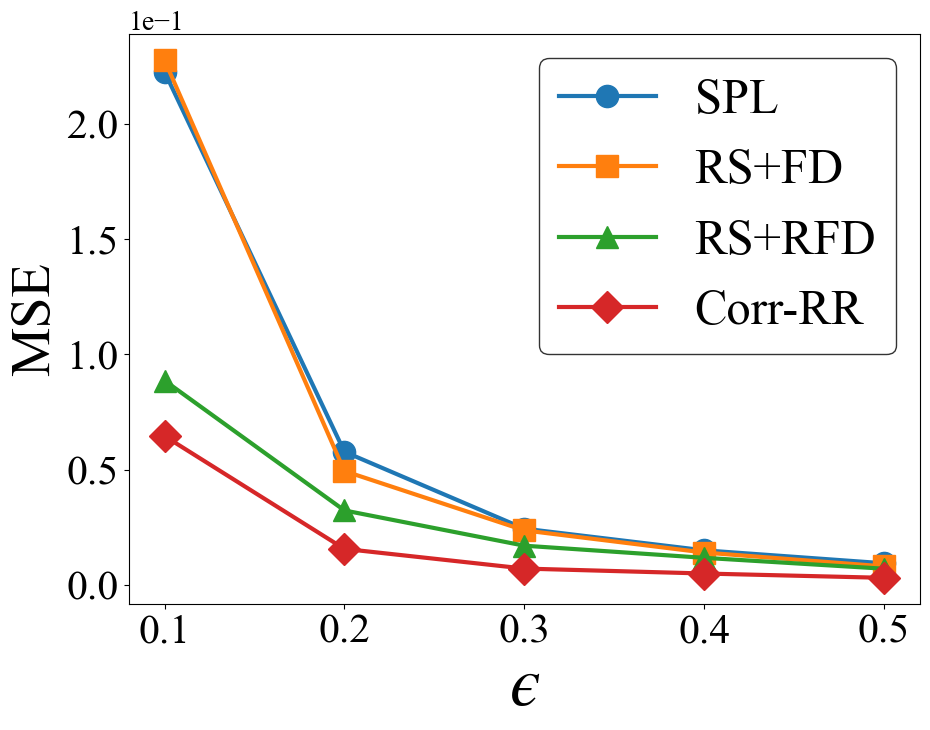

In [17]:

# ---------------- main ----------------
if __name__ == "__main__":
    eps = [0.1, 0.2, 0.3, 0.4, 0.5]

    # Data spec
    domain = [0, 1, 2, 3]
    x1_marginal = {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1}
    d = 4                # X1..X4 (all X2..X4 correlated to X1 with the same rho)
    rho = 0.1            # correlation to X1 for every other attribute
    q = None             # None => uniform base for non-copy draws

    means = sweep_all(
        n=20000,
        epsilons=eps,
        R=50,
        corr=rho,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig/data",
    )


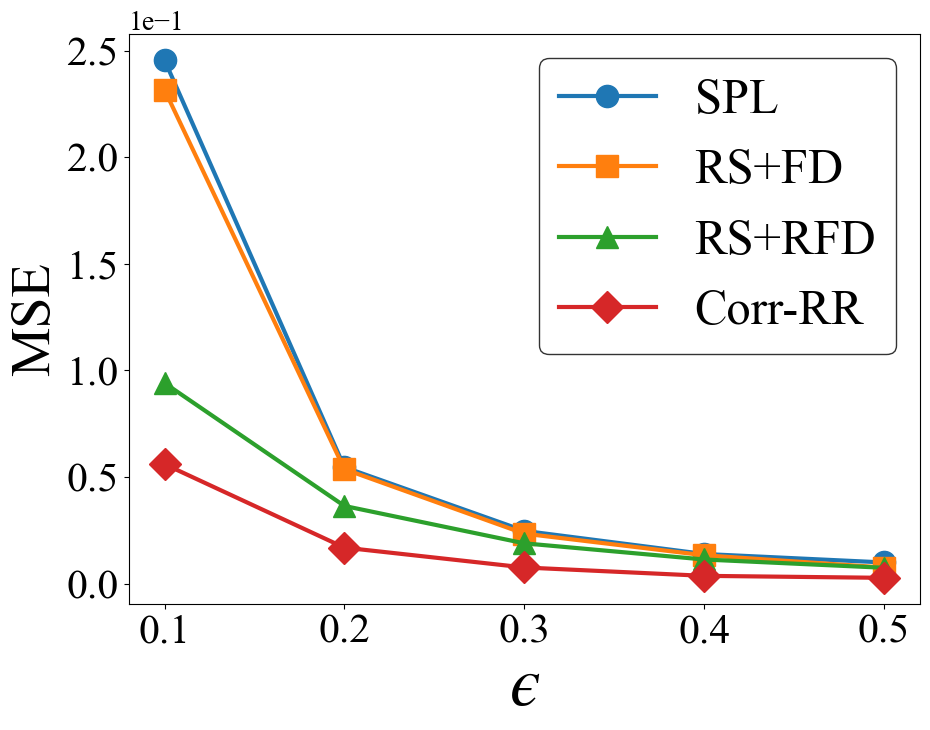

In [18]:

# ---------------- main ----------------
if __name__ == "__main__":
    eps = [0.1, 0.2, 0.3, 0.4, 0.5]

    # Data spec
    domain = [0, 1, 2, 3]
    x1_marginal = {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1}
    d = 4                # X1..X4 (all X2..X4 correlated to X1 with the same rho)
    rho = 0.5            # correlation to X1 for every other attribute
    q = None             # None => uniform base for non-copy draws

    means = sweep_all(
        n=20000,
        epsilons=eps,
        R=50,
        corr=rho,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig/data",
    )


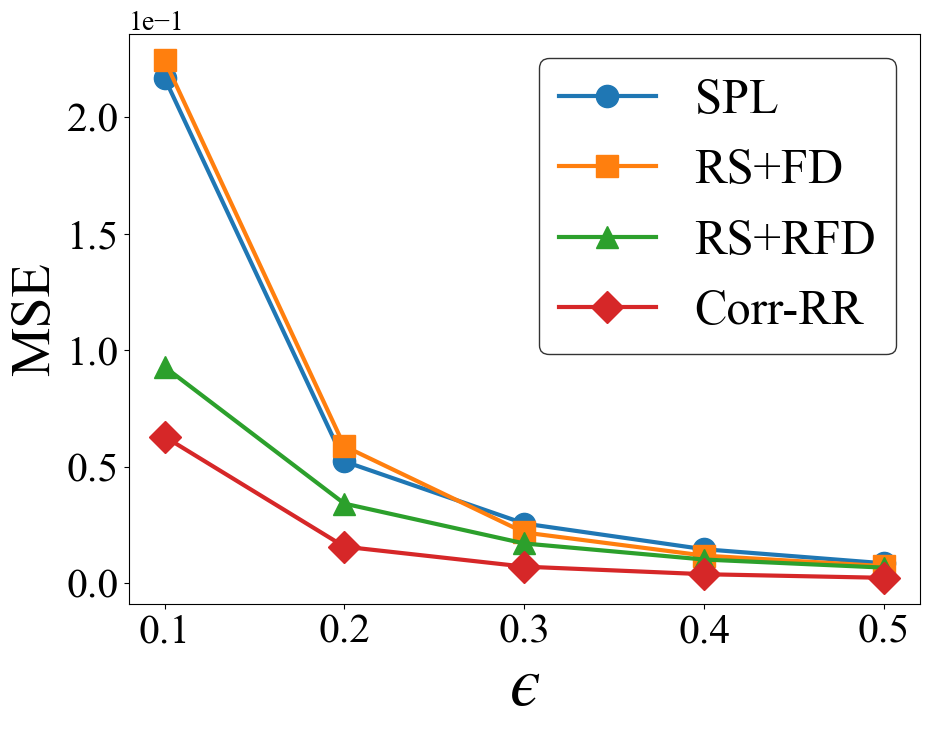

In [19]:

# ---------------- main ----------------
if __name__ == "__main__":
    eps = [0.1, 0.2, 0.3, 0.4, 0.5]

    # Data spec
    domain = [0, 1, 2, 3]
    x1_marginal = {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1}
    d = 4                # X1..X4 (all X2..X4 correlated to X1 with the same rho)
    rho = 0.95            # correlation to X1 for every other attribute
    q = None             # None => uniform base for non-copy draws

    means = sweep_all(
        n=20000,
        epsilons=eps,
        R=50,
        corr=rho,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig/data",
    )


[0.27679013]
[0.24266214]
[0.10845704]
[0.04951544]


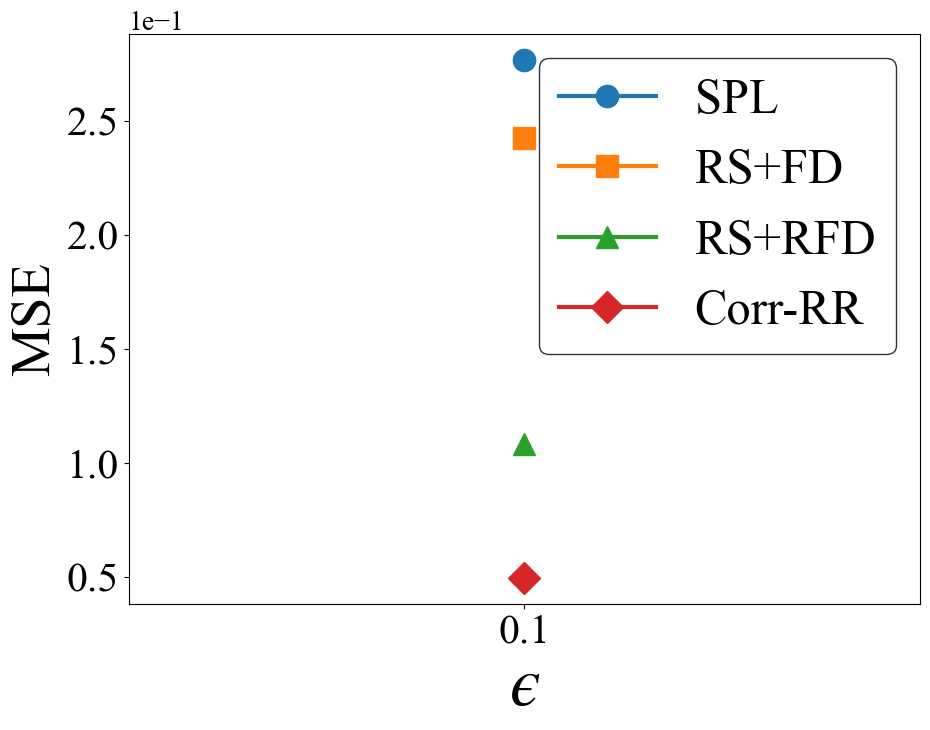

In [36]:
# run_with_new_generator_star.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# Typography / plot style (legends are mechanism names only)
mpl.rc('font', family='serif', serif=['Times New Roman'])
mpl.rcParams.update({
    'text.usetex': False,
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
})
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 30

# --- NEW: data utilities (star model) ---
from data_utils_newest import (
    gen_star_from_x1,       # <-- star/hub generator
    get_true_frequencies,
)

# --- baselines ---
from metrics import compute_mse
from spl import random_split_perturb, random_split_estimate
from rs_fd import rs_fd_perturb, rs_fd_estimate
from rs_rfd import rs_rfd_perturb, rs_rfd_estimate

from corr_rr_fixed_new import (
    corr_rr_phase1_spl,
    corr_rr_phase2_perturb,
    corr_rr_estimate,
    combine_phase_estimates,
    optimal_p_y,
    build_p_y_table,
)

# ---------------- helpers ----------------
def _normalize_dist(d):
    vals = np.array([max(0.0, float(v)) for v in d.values()], dtype=float)
    s = vals.sum()
    if s <= 0:
        k = len(vals)
        vals = np.full(k, 1.0 / k)
    else:
        vals = vals / s
    return {k: vals[i] for i, k in enumerate(d.keys())}

def _build_p_y_table_minimal(est_I, epsilon, n2, domain, cols):
    return {
        (a, b): float(optimal_p_y(est_I[a], est_I[b], epsilon, n2, domain))
        for a in cols for b in cols if a != b
    }

# ---------------- one-shot runner ----------------
def run_all_once(
    df,
    epsilon,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
):
    cols = list(df.columns)
    domains = {c: sorted(df[c].unique().tolist()) for c in cols}
    true_freqs = get_true_frequencies(df, cols)

    out = {}

    # SPL
    rpt = random_split_perturb(df, epsilon)
    est = random_split_estimate(rpt, df, epsilon)
    out["SPL"] = np.mean([compute_mse(true_freqs[c], est[c]) for c in cols])

    # RS+FD
    pert_rsfd = rs_fd_perturb(df, domains, epsilon)
    est_rsfd = rs_fd_estimate(pert_rsfd, domains, epsilon)
    out["RS+FD"] = np.mean([compute_mse(true_freqs[c], est_rsfd[c]) for c in cols])

    # RS+RFD (two-phase)
    est_I_rsrfd, df_B_rsrfd, doms_rsrfd = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_rsrfd)
    n1_rsrfd = len(df) - len(df_B_rsrfd)
    n2_rsrfd = len(df_B_rsrfd)
    priors_2p = {col: _normalize_dist(est_I_rsrfd[col]) for col in est_I_rsrfd}
    pert_rsrfd_2p = rs_rfd_perturb(df_B_rsrfd, doms_rsrfd, priors_2p, epsilon)
    est_II_rsrfd = rs_rfd_estimate(pert_rsrfd_2p, doms_rsrfd, priors_2p, epsilon)
    combined_rsrfd = combine_phase_estimates(est_I_rsrfd, est_II_rsrfd, n1_rsrfd, n2_rsrfd)
    out["RS+RFD"] = np.mean([compute_mse(true_freqs[c], combined_rsrfd[c]) for c in cols])

    # Corr-RR
    if use_corr_rr:
        est_I, df_B, doms_stable = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_corr)
        n1 = len(df) - len(df_B)
        n2 = len(df_B)
        common_domain = doms_stable[cols[0]]
        p_y_table = _build_p_y_table_minimal(est_I, epsilon, n2, common_domain, cols)
        pert_corr = corr_rr_phase2_perturb(df_B, epsilon, est_I, doms_stable, p_y_table)
        est_II = corr_rr_estimate(pert_corr, doms_stable, epsilon)
        combined_est = combine_phase_estimates(est_I, est_II, n1, n2)
        out["Corr-RR"] = np.mean([compute_mse(true_freqs[c], combined_est[c]) for c in cols])

    return out

# ---------------- sweep & plot ----------------
def sweep_all(
    n=10000,
    epsilons=(0.2, 0.4, 0.6, 0.8, 1.0),
    R=50,
    corr=0.9,                 # global rho: every Xj (j>=2) correlates to X1
    d=4,                      # total attributes generated
    domain=None,
    x1_marginal=None,         # marginal p for X1 (and X1 only)
    q_marginal=None,          # None => uniform for non-copy branch
    plot_dir=None,
    csv_dir=None,
    seed=None,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
):
    """
    Star model data: X1 ~ p; for j=2..d, Xj = X1 w.p. corr else ~ q.
    """
    if domain is None:
        domain = [0, 1]

    if x1_marginal is None:
        # default balanced marginal on the given domain
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(epsilons)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    attr_count = d
    domain_size = len(domain)

    for run in range(R):
        # ---- NEW: star generator ----
        df = gen_star_from_x1(
            n=n,
            domain=domain,
            d=d,
            x1_marginal=x1_marginal,
            rho=corr,
            q_marginal=q_marginal,
            seed=None if seed is None else (seed + run + int(1000 * corr)),
        )

        for j, eps in enumerate(epsilons):
            res = run_all_once(
                df,
                eps,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac_phase1_corr,
                frac_phase1_rsrfd=frac_phase1_rsrfd,
            )
            for k in keys:
                means[k][j] += res[k]

    for k in keys:
        means[k] /= R

    # Plot
    plt.figure(figsize=(10, 8))
    plt.plot(epsilons, means["SPL"],         '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(epsilons, means["RS+FD"],       '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(epsilons, means["RS+RFD"],      '-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(epsilons, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')
    print(means["SPL"])    
    print(means["RS+FD"])   
    print(means["RS+RFD"])  
    print(means["Corr-RR"])
    plt.xlabel(r'$ϵ$', fontsize=50)
    plt.ylabel('MSE',  fontsize=40)
    plt.xticks(epsilons, labels=[str(e) for e in epsilons])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.legend(fontsize=35, loc='upper right', frameon=True, edgecolor='black')
    plt.tight_layout()

    # Output filenames
    def _fmt(x): return f"{x:g}"
    base = f"mseVSepsilon_{attr_count}attr_{domain_size}domain_n_{n}_frac_{_fmt(frac_phase1_rsrfd)}_rho_{_fmt(corr)}"

    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, base + ".pdf"), format="pdf")

    plt.show()

    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        df_out = pd.DataFrame({"epsilon": list(epsilons)})
        for k in keys:
            df_out[k] = means[k]
        df_out.to_csv(os.path.join(csv_dir, base + ".csv"), index=False)

    return means


# ---------------- main ----------------
if __name__ == "__main__":
    eps = [0.1]

    # Data spec
    domain = [0, 1, 2, 3]
    x1_marginal = {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1}
    d = 4                # X1..X4 (all X2..X4 correlated to X1 with the same rho)
    rho = 0.92            # correlation to X1 for every other attribute
    q = None             # None => uniform base for non-copy draws

    means = sweep_all(
        n=20000,
        epsilons=eps,
        R=10,
        corr=rho,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        #plot_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig_e",
        #csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig_e/data",
    )



[0.24682441 0.05225886 0.02562842 0.01459303 0.00856876]
[0.22447961 0.05878706 0.02178187 0.01185511 0.00735112]
[0.10284823 0.03416349 0.01706695 0.01017682 0.00670233]
[0.04590588 0.01569311 0.00712575 0.00387835 0.00232316]
Saved: /Users/shafizurrahmanseeam/Desktop/cs/modified/mseVSepsilon_4attr_4domain_n_20000_frac_0.2_rho_0.95.pdf


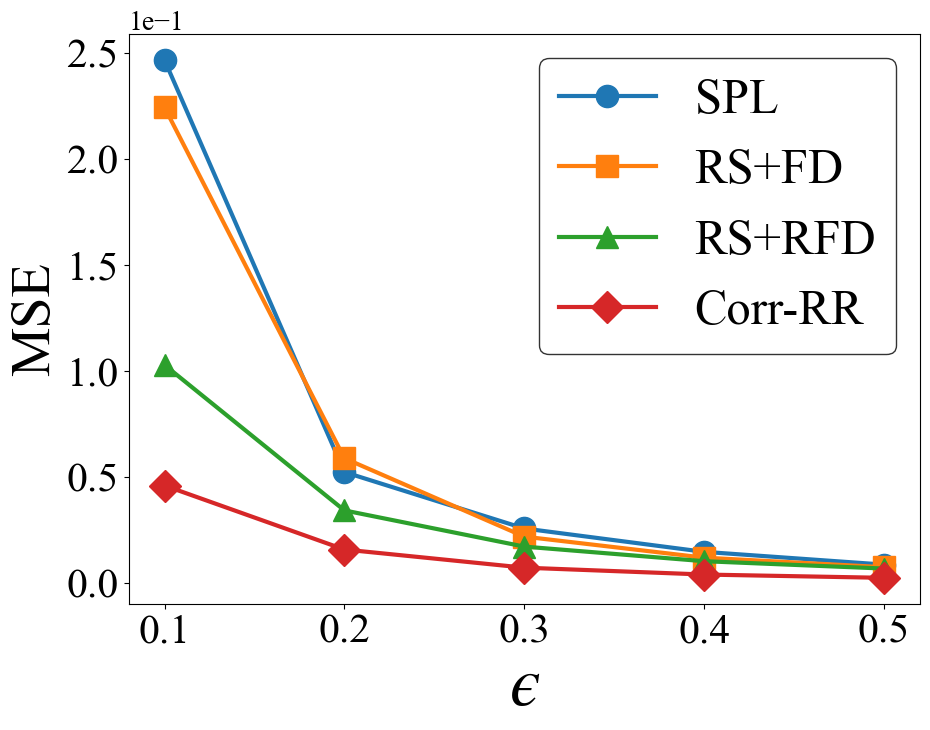

In [48]:
# plot_from_csvs.py
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# ---------- Typography / plot style (match your runner) ----------
mpl.rc('font', family='serif', serif=['Times New Roman'])
mpl.rcParams.update({
    'text.usetex': False,
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
})
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 30

EXPECTED_KEYS = ["SPL", "RS+FD", "RS+RFD", "Corr-RR"]

def plot_one_csv(csv_path: str, out_dir: str | None = None):
    df = pd.read_csv(csv_path)
    # Ensure expected columns exist (Corr-RR may or may not be present)
    available = [k for k in EXPECTED_KEYS if k in df.columns]

    epsilons = df["epsilon"].tolist()

    # -------- Plot (same style as your sweep_all) --------
    plt.figure(figsize=(10, 8))
    if "SPL" in available:
        plt.plot(epsilons, df["SPL"].values,   '-o', linewidth=3, markersize=16, label='SPL')
    if "RS+FD" in available:
        plt.plot(epsilons, df["RS+FD"].values, '-s', linewidth=3, markersize=16, label='RS+FD')
    if "RS+RFD" in available:
        plt.plot(epsilons, df["RS+RFD"].values,'-^', linewidth=3, markersize=16, label='RS+RFD')
    if "Corr-RR" in available:
        plt.plot(epsilons, df["Corr-RR"].values,'-D', linewidth=3, markersize=16, label='Corr-RR')

    # Optional: print the series (mirrors your prints)
    if "SPL" in available:     print(df["SPL"].values)
    if "RS+FD" in available:   print(df["RS+FD"].values)
    if "RS+RFD" in available:  print(df["RS+RFD"].values)
    if "Corr-RR" in available: print(df["Corr-RR"].values)

    plt.xlabel(r'$ϵ$', fontsize=50)
    plt.ylabel('MSE', fontsize=40)
    plt.xticks(epsilons, labels=[str(e) for e in epsilons])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.legend(fontsize=35, loc='upper right', frameon=True, edgecolor='black')
    plt.tight_layout()

    # Save next to CSV unless out_dir provided
    base = os.path.splitext(os.path.basename(csv_path))[0]
    save_dir = out_dir if out_dir else os.path.dirname(csv_path)
    os.makedirs(save_dir, exist_ok=True)
    pdf_path = os.path.join(save_dir, base + ".pdf")
    plt.savefig(pdf_path, format="pdf")
    print(f"Saved: {pdf_path}")

def plot_all_csvs(csv_dir: str, out_dir: str | None = None, pattern: str = "*.csv"):
    paths = sorted(glob.glob(os.path.join(csv_dir, pattern)))
    if not paths:
        print(f"No CSV files found in {csv_dir} with pattern {pattern}.")
        return
    for p in paths:
        plot_one_csv(p, out_dir)

if __name__ == "__main__":
    # --- Edit these as needed ---
    CSV_DIR = "/Users/shafizurrahmanseeam/Desktop/cs/modified/data"   # folder where your sweep_all() CSVs were saved
    OUT_DIR = "/Users/shafizurrahmanseeam/Desktop/cs/modified"                       # or set to a folder for PDFs; None = same as CSV_DIR
    PATTERN = "*.csv"                   # keep default or narrow to your base prefix

    plot_all_csvs(CSV_DIR, out_dir=OUT_DIR, pattern=PATTERN)
